# CLIP Pipeline

## Preparation

In [2]:
import sys, os

# sys path hack to allow importing the encoding functions
sys.path.insert(0, os.path.abspath('../encoding'))

In [3]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from transformers import CLIPProcessor, CLIPImageProcessor, CLIPTokenizer, TFCLIPModel

model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-04-02 14:07:52.054756: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-02 14:07:52.054797: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


### Sanity Check

tf.Tensor([-0.30086833 -0.31299886 -0.18385744], shape=(3,), dtype=float32)
tf.Tensor([[30.08683  31.299883 18.38574 ]], shape=(1, 3), dtype=float32)


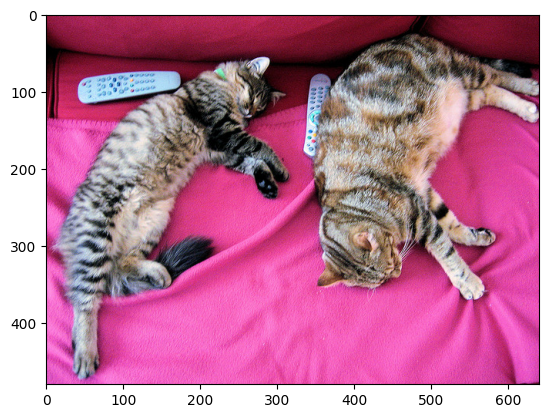

In [5]:
from PIL import Image
import requests
import tensorflow as tf
import matplotlib.pyplot as plt

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

plt.imshow(image)

inputs = processor(text=["two cats lying on a couch", "two cats and two remotes", "two dolphins in the water"], images=image, return_tensors="tf", padding=True)

cosine_similarity = tf.keras.losses.CosineSimilarity(reduction=tf.keras.losses.Reduction.NONE)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
print(cosine_similarity(outputs.text_embeds, outputs.image_embeds))
print(logits_per_image)

### Reference Question

Is the frosting on the plate? -> yes
select: frosting (3402690)->verify rel: plate,on,o (2236804) [0]


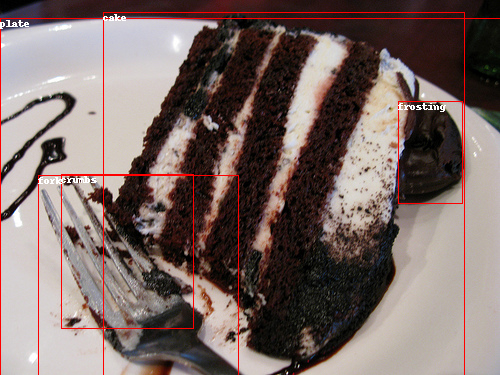

In [7]:
from PIL import Image, ImageDraw
import json

with open("../data/questions/train_sampled_questions_2000.json") as f:
   questions = list(json.load(f).items())

qid, question = questions[7]
print(f"{question['question']} -> {question['answer']}")
print(question['semanticStr'])
image = Image.open(f"../data/images/{question['imageId']}.jpg")

imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

for object in question['sceneGraph']['objects'].values():
   object_crop = image.crop((object['x'], object['y'], object['x']+object['w'], object['y']+object['h']))
   draw.rectangle((object['x'], object['y'], object['x']+object['w'], object['y']+object['h']), outline="red", width=1)
   draw.text((object['x'], object['y']), object["name"], fill="white")

imgcopy

## Concept Extraction

In [8]:
import json 
import re
from pattern.text.en import singularize

with open('../data/metadata/gqa_all_attribute.json') as f:
    all_attributes = json.load(f)

def sanitize(name):
    # source: DFOL-VQA
    plurale_tantum = ['this', 'yes', 'pants', 'shorts', 'glasses', 'scissors', 'panties', 'trousers', 'binoculars', 'pliers', 'tongs',\
        'tweezers', 'forceps', 'goggles', 'jeans', 'tights', 'leggings', 'chaps', 'boxers', 'indoors', 'outdoors', 'bus', 'octapus', 'waitress',\
        'pasta', 'pita', 'glass', 'asparagus', 'hummus', 'dress', 'cafeteria', 'grass', 'class']

    irregulars = {'shelves': 'shelf', 'bookshelves': 'bookshelf', 'olives': 'olive', 'brownies': 'brownie', 'cookies': 'cookie'}
    
    temp = name.strip().lower()
    if temp in irregulars:
        temp = irregulars[temp]
    elif not (temp.split(' ')[-1] in plurale_tantum or temp[-2:] == 'ss'):
        temp = singularize(temp)
        
    return temp


def cleanup_whitespace(name):
    cleanup_regex = r'[^\w]'
    return re.sub(cleanup_regex, '_', name)


def sanitize_asp(name):
    return cleanup_whitespace(sanitize(name))


def extract_attributes(question):
    attributes = set()
    standalone_values = set()
    for operation in question['semantic']:
        op = operation['operation']
        if op == 'relate':
            relation_type = operation['argument'].split(',')[1]
            if relation_type.startswith('same '):
                attributes.add(relation_type[5:])
        elif op == 'query':
            attributes.add(operation['argument'])
        elif op == 'common':
            attributes.update(all_attributes.keys())
        elif (op == 'same' or op == 'different') and \
             operation['argument'] != 'type':
            attributes.add(operation['argument'])
        elif op == 'filter':
            if operation['argument'].startswith('not('):
                standalone_values.add(operation['argument'][4:-1])
            else:
                standalone_values.add(operation['argument'])
        elif op == 'choose':
            standalone_values.add(operation['argument'].split('|')[0])
            standalone_values.add(operation['argument'].split('|')[1])
        elif operation['operation'] == 'verify':
            standalone_values.add(operation['argument'])
        elif op.startswith('filter') or \
             (op.startswith('verify') and op != 'verify rel') or \
             op.startswith('same') or \
             op.startswith('different'):
            attributes.add(' '.join(op.split(' ')[1:]))
        elif op.startswith('choose') and \
             op != 'choose rel' and operation['argument'] != '':
            attributes.add(' '.join(op.split(' ')[1:]))
        
    return {sanitize(a) for a in attributes if a != 'name' and a != 'vposition' and a != 'hposition'}, \
           {sanitize(v) for v in standalone_values}


def extract_classes(question):
    classes = set()
    for operation in question['semantic']:
        if operation['operation'] == 'select':
            classes.add(operation['argument'].split('(')[0])
        elif operation['operation'] == 'relate':
            target_class = operation['argument'].split(',')[0]
            if target_class != '_':
                classes.add(target_class)
        elif operation['operation'] == 'choose rel':
            classes.add(operation['argument'].split(',')[0])
        elif operation['operation'] == 'verify rel':
            classes.add(operation['argument'].split(',')[0])
    return {sanitize(c) for c in classes}


def extract_relations(question):
    relations = set()
    for operation in question['semantic']:
        if operation['operation'] == 'relate':
            relation = operation['argument'].split(',')[1]
            if not relation.startswith('same '):
                relations.add(relation)
        elif operation['operation'] == 'choose rel':
            relations.add(operation['argument'].split(',')[1].split('|')[0])
            relations.add(operation['argument'].split(',')[1].split('|')[1])
        elif operation['operation'] == 'verify rel':
            relations.add(operation['argument'].split(',')[1])
    return {sanitize(r) for r in relations}
        

In [9]:
print(question['semanticStr'])
print(extract_attributes(question))
print(extract_classes(question))
print(extract_relations(question))

select: frosting (3402690)->verify rel: plate,on,o (2236804) [0]
(set(), set())
{'frosting', 'plate'}
{'on'}


## Bounding Box Optimization

In [10]:
from math import tanh, exp
import numpy as np


def scaling(x, ceiling=3):
    return (1 - tanh(x * 2)) * ceiling


def get_object_bboxes(question, padding_scale_ceiling=1):
    img_width = question['sceneGraph']['width'] - 1
    img_height = question['sceneGraph']['height'] - 1

    padding_w = scaling(object['w'] / img_width, padding_scale_ceiling) * object['w']
    padding_h = scaling(object['h'] / img_height, padding_scale_ceiling) * object['h']

    return [(
        max(object['y'] - padding_h, 0),
        max(object['x'] - padding_w, 0),
        min(object['y']+object['h']+padding_h, img_height),
        min(object['x']+object['w']+padding_h, img_width)
    ) for object in question['sceneGraph']['objects'].values()]

def should_merge(box1, box2, overlap_threshold):
    YA1, XA1, YA2, XA2 = box1 
    YB1, XB1, YB2, XB2 = box2
    box1_area = (YA2 - YA1) * (XA2 - XA1)
    box2_area = (YB2 - YB1) * (XB2 - XB1)
    intersection_area = max(0, min(XA2, XB2) - max(XA1, XB1)) * max(0, min(YA2, YB2) - max(YA1, YB1))
    union_area = box1_area + box2_area - intersection_area

    if intersection_area / union_area > overlap_threshold:
        return True, (
            min(box1[0], box2[0]),
            min(box1[1], box2[1]),
            max(box1[2], box2[2]),
            max(box1[3], box2[3]),
        )

    return False, None

def merge_boxes(boxes, overlap_threshold):
    for k in range(len(boxes)):
        indices1, box1 = boxes[k]
        for l in range(k+1, len(boxes)):
            indices2, box2 = boxes[l]
            is_merge, new_box = should_merge(box1, box2, overlap_threshold)
            if is_merge:
                boxes[k] = None
                boxes[l] = (indices1.union(indices2), new_box)
                break

    boxes = [b for b in boxes if b]
    return boxes 

def get_pair_bboxes(question, merge_threshold = 0.7):
    num_objects = len(question['sceneGraph']['objects'].values())
    bbox_indices = np.full([num_objects, num_objects], -1)
    
    joined_bboxes = []
    for i in range(num_objects):
        for j in range(i+1, num_objects):
            object1 = list(question['sceneGraph']['objects'].values())[i]
            object2 = list(question['sceneGraph']['objects'].values())[j]

            joined_bboxes.append(({(i,j)}, (
                min(object1['y'], object2['y']),
                min(object1['x'], object2['x']),
                max(object1['y'] + object1['h'], object2['y'] + object2['h']),
                max(object1['x'] + object1['w'], object2['x'] + object2['w']),
            )))

    merged_boxes = merge_boxes(joined_bboxes, merge_threshold)
    for k, (indices, _) in enumerate(merged_boxes):
        for i,j in indices:
            bbox_indices[i,j] = k
            bbox_indices[j,i] = k

    return [box for _, box in merged_boxes], bbox_indices


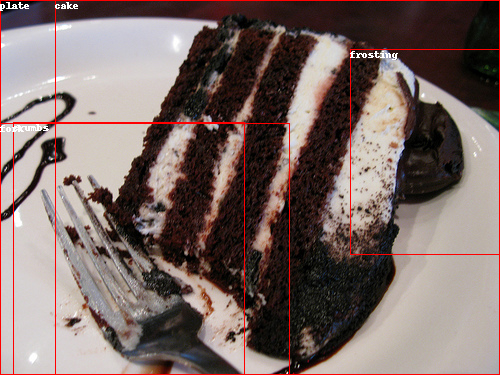

In [11]:
objects = list(question['sceneGraph']['objects'].values())
object_bboxes = get_object_bboxes(question)

imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

for i, object in enumerate(objects[:5]):
    bbox = object_bboxes[i]

    draw.rectangle((bbox[1], bbox[0], bbox[3], bbox[2]), outline="red", width=1)
    draw.text((bbox[1], bbox[0]), f"{object['name']}", fill="white")

imgcopy

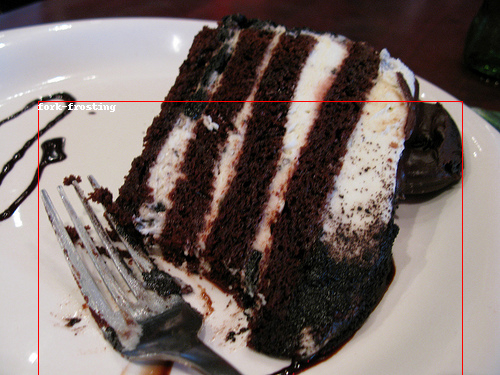

In [12]:
object_pairs = [(2,4)]
pair_bboxes, pair_bbox_indices = get_pair_bboxes(question)

imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

for object_pair in object_pairs:
    bbox = pair_bboxes[pair_bbox_indices[object_pair[0], object_pair[1]]]

    draw.rectangle((bbox[1], bbox[0], bbox[3], bbox[2]), outline="red", width=1)
    draw.text((bbox[1], bbox[0]), f"{objects[object_pair[0]]['name']}-{objects[object_pair[1]]['name']}", fill="white")

imgcopy

## Scene Encoding

In [13]:
import tensorflow as tf 

def bboxes_to_image_inputs(bboxes, image):    
    img_height = image.shape[0]
    img_width = image.shape[1]

    bboxes_scaled = tf.convert_to_tensor([[y1/img_height, x1/img_width, y2/img_height, x2/img_width] for (y1,x1,y2,x2) in bboxes])
    box_indices = tf.constant(0, shape=(len(bboxes),))

    object_crops = tf.cast(tf.image.crop_and_resize(tf.expand_dims(image, axis=0), bboxes_scaled, box_indices, (224,224)), dtype=tf.uint8)

    return image_processor(tf.unstack(object_crops), return_tensors="tf", do_resize=False, do_center_crop=False)


def prompts_to_text_inputs(text_prompts):
    return tokenizer(text=text_prompts, return_tensors="tf", padding=True)


def get_scene_encoding(question):
    scene_encoding = ""

    # add attributes derived from object detection (names, vposition/hposition)
    scene_graph = question['sceneGraph']
    for oid, object in scene_graph['objects'].items():
        scene_encoding += f"object({oid}).\n"

        # scene_encoding += f"has_attribute({oid}, class, {sanitize_asp(object['name'])}).\n"
        scene_encoding += f"has_attribute({oid}, name, {sanitize_asp(object['name'])}).\n"

        if (object['x'] + object['w']/2) > scene_graph['width']/3*2:
            scene_encoding += f"has_attribute({oid}, hposition, right).\n"
        elif (object['x'] + object['w']/2) > scene_graph['width']/3:
            scene_encoding += f"has_attribute({oid}, hposition, middle).\n"
        else:
            scene_encoding += f"has_attribute({oid}, hposition, left).\n"

        if (object['y'] + object['h']/2) > scene_graph['height']/3*2:
            scene_encoding += f"has_attribute({oid}, vposition, bottom).\n"
        if (object['y'] + object['h']/2) > scene_graph['height']/3:
            scene_encoding += f"has_attribute({oid}, vposition, middle).\n"
        else:
            scene_encoding += f"has_attribute({oid}, vposition, top).\n"
        scene_encoding += "\n"

    tf_image = tf.io.decode_jpeg(tf.io.read_file(f"../data/images/{question['imageId']}.jpg"), channels=3)
    objects = question['sceneGraph']['objects'].values()
    attributes, standalone_values = extract_attributes(question)
    classes = extract_classes(question)
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1, reduction=tf.keras.losses.Reduction.NONE)

    # get cosine similarities between attribute/class values and every object's image crop
    if len(attributes) > 0 or len(standalone_values) > 0 or len(classes) > 0:
        object_bboxes = get_object_bboxes(question)
        attr_prompts = [f"a {val} {object['name']}" for object in objects for attr in attributes for val in all_attributes.get(attr, [])]
        standalone_value_prompts = [f"a {val} {object['name']}" for object in objects for val in standalone_values]
        class_prompts = [f"a {class_}" for class_ in classes ]
        obj_image_inputs = bboxes_to_image_inputs(object_bboxes, tf_image)
        obj_text_inputs = prompts_to_text_inputs([*attr_prompts, *standalone_value_prompts, *class_prompts])

        obj_outputs = model(**obj_image_inputs, **obj_text_inputs)
        num_attr_values = sum(len(all_attributes.get(attr, [])) for attr in attributes)
        num_standalone_values = len(standalone_values)

        if len(attributes) > 0:
            attr_image_embeds = tf.repeat(obj_outputs['image_embeds'], repeats=(tf.ones((obj_outputs['image_embeds'].shape[0]), dtype=tf.int32) * num_attr_values), axis=0)
            attr_text_embeds = obj_outputs['text_embeds'][:num_attr_values*len(objects),]
            # print(attr_image_embeds.shape)
            # print(attr_text_embeds.shape)
            attr_cosine_loss = cosine_loss(attr_image_embeds, attr_text_embeds).numpy()

            i = 0
            for oid, object in question['sceneGraph']['objects'].items():
                for attr in attributes:
                    options = [f"has_attribute({oid}, {cleanup_whitespace(attr)}, {cleanup_whitespace(val)})" for val in all_attributes.get(attr, [])]
                    scene_encoding += f"{{ {'; '.join(options)} }} = 1 .\n"
                    for val in all_attributes.get(attr, []):
                        scene_encoding += f":~ has_attribute({oid}, {cleanup_whitespace(attr)}, {cleanup_whitespace(val)}). [{round(500 + 1000*attr_cosine_loss[i])}]\n"
                        i += 1 
                scene_encoding += "\n"

        if len(standalone_values) > 0:
            standalone_value_image_embeds = tf.repeat(obj_outputs['image_embeds'], repeats=(tf.ones((obj_outputs['image_embeds'].shape[0]), dtype=tf.int32) * len(standalone_values)), axis=0)
            standalone_value_text_embeds = obj_outputs['text_embeds'][num_attr_values*len(objects):(num_attr_values+num_standalone_values)*len(objects),]
            # print(standalone_value_image_embeds.shape)
            # print(standalone_value_text_embeds.shape)
            standalone_value_cosine_loss = cosine_loss(standalone_value_image_embeds, standalone_value_text_embeds).numpy()

            for standalone_value_ in standalone_values:
                scene_encoding += f"{{ has_attribute(OID, any, {cleanup_whitespace(standalone_value_)}) : object(OID) }} >= 1 .\n"
            scene_encoding += "\n"

            j = 0 
            for oid, object in question['sceneGraph']['objects'].items():
                for standalone_value_ in standalone_values:
                    scene_encoding += f":~ has_attribute({oid}, any, {cleanup_whitespace(standalone_value_)}). [{round(500 + 1000*standalone_value_cosine_loss[j])}]\n"
                    j += 1
        
        if len(classes) > 0:
            class_image_embeds = tf.repeat(obj_outputs['image_embeds'], repeats=(tf.ones((obj_outputs['image_embeds'].shape[0]), dtype=tf.int32) * len(classes)), axis=0)
            class_text_embeds = tf.tile(obj_outputs['text_embeds'][(num_attr_values+num_standalone_values)*len(objects):,], tf.constant([len(objects), 1], tf.int32))
            # print(class_image_embeds.shape)
            # print(class_text_embeds.shape)
            class_cosine_loss = cosine_loss(class_image_embeds, class_text_embeds).numpy()

            for class_ in classes:
                scene_encoding += f"{{ has_attribute(OID, class, {cleanup_whitespace(class_)}) : object(OID) }} >= 1 .\n"
            scene_encoding += "\n"

            j = 0 
            for oid, object in question['sceneGraph']['objects'].items():
                for class_ in classes:
                    scene_encoding += f":~ has_attribute({oid}, class, {cleanup_whitespace(class_)}). [{round(500 + 1000*class_cosine_loss[j])}]\n"
                    j += 1

    # get cosine similarities between relations and every object pair's image crop
    relations = extract_relations(question)
    if len(relations) > 0:
        rel_bboxes, rel_bbox_indices = get_pair_bboxes(question, merge_threshold=0.6)
        rel_prompts = [f"a {object1['name']} {rel} a {object2['name']}" for rel in relations for i, object1 in enumerate(objects) for j, object2 in enumerate(objects)]
        rel_image_inputs = bboxes_to_image_inputs(rel_bboxes, tf_image)
        rel_text_inputs = prompts_to_text_inputs(rel_prompts)
        
        print(f"Number of relation bboxes: {len(rel_bboxes)}")
        rel_outputs = model(**rel_image_inputs, **rel_text_inputs)

        rel_image_embeds = tf.tile(tf.gather(rel_outputs['image_embeds'], indices=tf.reshape(rel_bbox_indices, [len(objects)*len(objects)]), axis=0), tf.constant([len(relations), 1], tf.int32))
        rel_text_embeds = rel_outputs['text_embeds']
        # print(rel_image_embeds.shape)
        # print(rel_text_embeds.shape)
        rel_cosine_loss = cosine_loss(rel_image_embeds, rel_text_embeds).numpy()

        scene_encoding += "\n"
        k = 0
        for rel in relations:
            scene_encoding += f"{{ has_relation(OID1, {cleanup_whitespace(rel)}, OID2) : object(OID1), object(OID2) }} >= 1 .\n"                
            for oid1, object1 in question['sceneGraph']['objects'].items():
                for oid2, object2 in question['sceneGraph']['objects'].items():
                    if oid1 != oid2:
                        scene_encoding += f":~ has_relation({oid1}, {cleanup_whitespace(rel)}, {oid2}). [{round(500 + 1000*rel_cosine_loss[k])}]\n"
                    k += 1
            scene_encoding += "\n"
    
    return scene_encoding
    

## Testing

In [14]:
from encode import encode_question
from clingo.control import Control 
from itertools import islice

with open('../encoding/theory.lp') as theory_file:
    theory = theory_file.read()

num_questions = 10
correct = 0
incorrect = 0

def answer_is_correct(answers, correct_answer):
    correct = False 

    for answer in answers:
        if answer == sanitize_asp(correct_answer): 
            correct = True
        elif (answer == 'to_the_right_of' and correct_answer == 'right') or \
            (answer == 'to_the_left_of' and correct_answer == 'left') or \
            (answer == 'in_front_of' and correct_answer == 'front'):
            correct = True
    return correct 

for qid, question in islice(questions, 0, num_questions):
    print(f"Attempting to solve question {qid}")
    if question['semantic'][0]['operation'] == 'select' and question['semantic'][0]['argument'] == 'scene':
        num_questions = num_questions - 1
        continue

    ctl = Control()
    ctl.add(theory)

    scene_encoding = get_scene_encoding(question)
    question_encoding = encode_question(question)

    with open(f"../data/encoded_questions/{qid}.lp", "w") as f:
        f.write("% ------ scene encoding ------\n")
        f.write(scene_encoding)
        f.write("\n% ------ question encoding ------\n")
        f.write(question_encoding)

    ctl.add(scene_encoding)
    ctl.add(question_encoding)

    answers = [[]]
    def on_model(model):
        answers[0] = [s.arguments[0].name for s in model.symbols(shown=True)]

    ctl.ground()
    handle = ctl.solve(on_model=on_model, async_ = True)
    has_finished = handle.wait(timeout=10.0)
    
    if not has_finished:
        print("Search was timed out after 10 seconds!")
    
    if len(answers[0]) > 0:
        if(answer_is_correct(answers[0], question['answer'])):
            print(f"Question {qid}: correct answer: {answers[0][0]}")
            correct = correct + 1
        else: 
            print(f"Question {qid}: incorrect answer: {answers[0][0]} (correct: {question['answer']})")
            incorrect = incorrect + 1
    else: 
        print(f"Question {qid}: UNSAT")
        incorrect = incorrect + 1

print("===============================")
print(f"Total questions: {num_questions}")
print(f"Correct: {correct}")
print(f"Incorrect: {incorrect}")
print(f"Percentage: {correct/num_questions*100}%")

Attempting to solve question 07787914
Question 07787914: incorrect answer: yes (correct: no)
Attempting to solve question 19560907
Number of relation bboxes: 63
Question 19560907: incorrect answer: pillow (correct: man)
Attempting to solve question 07328145
Number of relation bboxes: 50
Question 07328145: incorrect answer: man (correct: boats)
Attempting to solve question 17680743
Number of relation bboxes: 46
Question 17680743: incorrect answer: pizza (correct: oven)
Attempting to solve question 09455791
Number of relation bboxes: 27
Question 09455791: incorrect answer: arm (correct: blanket)
Attempting to solve question 13412818
Number of relation bboxes: 83
Question 13412818: correct answer: no
Attempting to solve question 11717959
Search was timed out after 10 seconds!
Question 11717959: incorrect answer: khaki (correct: black)
Attempting to solve question 141015736
Number of relation bboxes: 2
Question 141015736: incorrect answer: no (correct: yes)
Attempting to solve question 141